In [2]:
using DrWatson
@quickactivate "TriangularHubbard"
using TriangularHubbard

using PyCall
using PyPlot

using LinearAlgebra
using JSON
using DBInterface
using SQLite
using DataFrames
using DataFramesMeta
using LsqFit
using Printf
using Quadmath
using ProgressMeter
using Dates
using NLsolve
using CSV
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")
sp = pyimport("scipy")
pyimport("scipy.spatial")

backend_pdf = pyimport("matplotlib.backends.backend_pdf")

PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

  Activating project at `/gpfs/research/changlani/Lee_project/TriangularHubbard`


In [3]:
include("processdata.jl")

compute_grand_canonical (generic function with 2 methods)

In [4]:
shape_str = "(2,-2)x(2,4)"

"(2,-2)x(2,4)"

In [5]:
latticedata = read_lattice_data(datadir("lattice-$shape_str.json"));

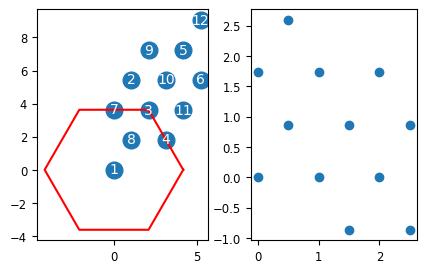

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /gpfs/home/kyungminlee_42/.julia/packages/PyCall/BD546/src/numpy.jl:67


In [6]:
fig = PyPlot.figure(figsize=(5,3))
ax = fig.add_subplot(1,2,1)
ax.plot(2π * latticedata.momentums[1,:], 2π * latticedata.momentums[2,:], "o", markersize=12)
for i in 1:size(latticedata.momentums, 2)
    ax.text(2π * latticedata.momentums[1,i], 2π * latticedata.momentums[2,i], "$i", ha="center", va="center", color="w")
end
ax.set_aspect(1.0)
ax.plot(latticedata.zone_boundary[1,:], latticedata.zone_boundary[2,:], "r-")

ax = fig.add_subplot(1,2,2)
ax.plot(latticedata.sitecoordinates[1,:], latticedata.sitecoordinates[2,:], "o")
ax.set_aspect(1.0)

In [7]:
kpoint_indices = Dict("GM" => 1, "K" => 3, "M" => 4, "LD" => 8);

In [8]:
df = read_data(datadir("curie", shape_str, "sectors.sqlite3"), kpoint_indices);

In [9]:
process_data!(df, latticedata)

In [11]:
include("processdata.jl")

compute_grand_canonical (generic function with 2 methods)

In [12]:
# check_data(df)

In [13]:
let sdf = filter(row -> !isapprox(row.uu_GM, row.nup.^2 * row.partition), df)
    @show unique(sdf.idx)
    @show unique(sdf.type)
end

sdf = filter(row -> !isapprox(row.uu_GM, row.nup.^2 * row.partition), df);

unique(sdf.idx) = Int64[]
unique(sdf.type) = String[]


In [14]:
let sdf = filter(row -> !isapprox(row.ud_GM, row.nup * row.ndn * row.partition), df)
    @show unique(sdf.idx)
    @show unique(sdf.type)
end

sdf = filter(row -> !isapprox(row.ud_GM, row.nup * row.ndn * row.partition), df);

unique(sdf.idx) = Int64[]
unique(sdf.type) = String[]


In [15]:
let sdf = filter(row -> !isapprox(row.du_GM, row.nup * row.ndn * row.partition), df)
    @show unique(sdf.idx)
    @show unique(sdf.type)
end

sdf = filter(row -> !isapprox(row.du_GM, row.nup * row.ndn * row.partition), df);

unique(sdf.idx) = Int64[]
unique(sdf.type) = String[]


In [16]:
let sdf = filter(row -> !isapprox(row.dd_GM, row.ndn^2 * row.partition), df)
    @show unique(sdf.idx)
    @show unique(sdf.type)
end

sdf = filter(row -> !isapprox(row.dd_GM, row.ndn^2 * row.partition), df);

unique(sdf.idx) = Int64[]
unique(sdf.type) = String[]


In [17]:
# select!(df, Not(:correlation));

In [18]:
temperatures = unique(sort(df.temperature))
charges = unique(sort(df.charge))
;

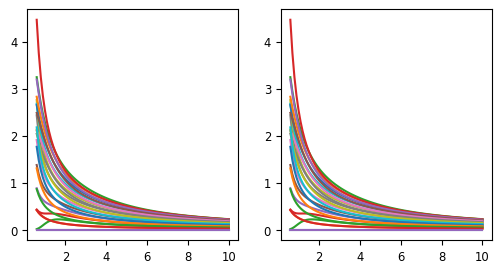

In [19]:
checkplot(df)

In [20]:
include("processdata.jl")

compute_grand_canonical (generic function with 2 methods)

In [21]:
canonical_df = filter(
    row -> 0.4 <= row.density <= 1.7,
    compute_canonical(df, kpoint_indices)
);

In [22]:
@. model(x, p) = (x - p[2]) / p[1]

canonical_fit_df = compute_canonical_fit(
    canonical_df,
    model,
    [0.7, 5.5],
    latticedata,
)

16×11 DataFrame
 Row │ density   intercept_0  intercept_M  intercept_GM  intercept_K  intercep ⋯
     │ Float64   Float64      Float64      Float64       Float64      Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.416667  -0.514031      0.101199    -0.514031     0.0953727     -0.029 ⋯
   2 │ 0.5       -0.379604      0.110164    -0.379604     0.110959      -0.043
   3 │ 0.583333  -0.303389      0.117806    -0.303389     0.129179      -0.050
   4 │ 0.666667  -0.272894      0.125341    -0.272894     0.151241      -0.048
   5 │ 0.75      -0.272346      0.132312    -0.272346     0.17665       -0.035 ⋯
   6 │ 0.833333  -0.264189      0.145349    -0.264189     0.20478       -0.010
   7 │ 0.916667  -0.21739       0.175433    -0.21739      0.241303       0.033
   8 │ 1.0       -0.0971328     0.255126    -0.0971328    0.298132       0.125
   9 │ 1.08333    0.0153929     0.127083     0.0153929    0.150347       0.082 ⋯
  10 │ 1.16667   -0.0530696     0.0670306   -0.0530696    0.0766368      0.074
  11 │ 1.25      -0.111324      0.0419713   -0.111324     0.0337536      0.066
  12 │ 1.33333   -0.138299      0.0327287   -0.138299     0.00543214     0.056
  13 │ 1.41667   -0.124295      0.0309889   -0.124295    -0.0172881      0.046 ⋯
  14 │ 1.5       -0.0807949     0.029315    -0.0807949   -0.0346171      0.035
  15 │ 1.58333   -0.0320206     0.0249312   -0.0320206   -0.0456231      0.026
  16 │ 1.66667   -0.00768454    0.0204315   -0.00768454  -0.0488197      0.019
                                                               6 columns omitted

In [55]:
CSV.write("canonical_$(shape_str).csv", canonical_df)
CSV.write("canonical-fit_$(shape_str).csv", canonical_fit_df)

"canonical-fit_(2,-2)x(2,4).csv"

In [23]:
densities = unique(sort(canonical_fit_df.density));

In [24]:
# ncols_rho = Int(ceil(sqrt(length(select_densities))))
# nrows_rho = Int(ceil(length(select_densities) / ncols_rho))
# println(length(select_densities), ", ", nrows_rho, ", ", ncols_rho)

select_temperatures = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
select_temperature_lookup = Dict(v => i for (i, v) in enumerate(select_temperatures))
nrows_T, ncols_T = 3, 3
;

In [25]:
# panels = (
#     nrows=nrows_rho,
#     ncols=ncols_rho,
#     select_density_lookup=select_density_lookup
# )

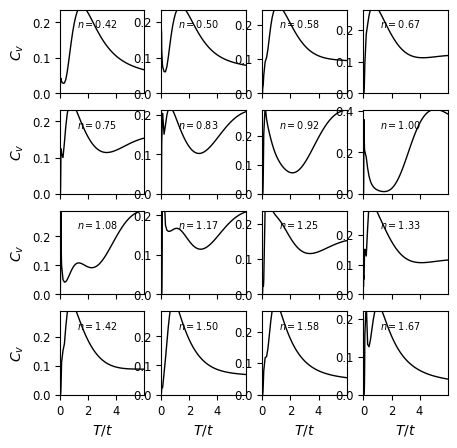

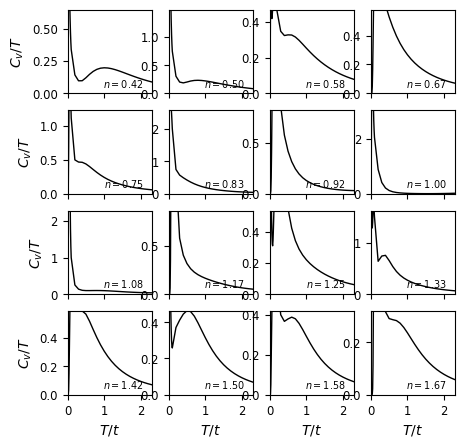

In [26]:
plot_specific_heat(canonical_df, 4, 4; prefix="canonical_")

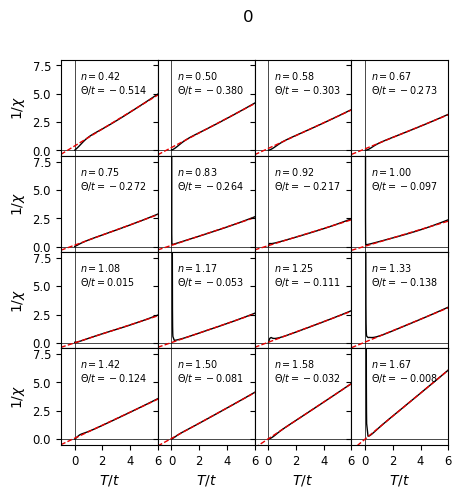

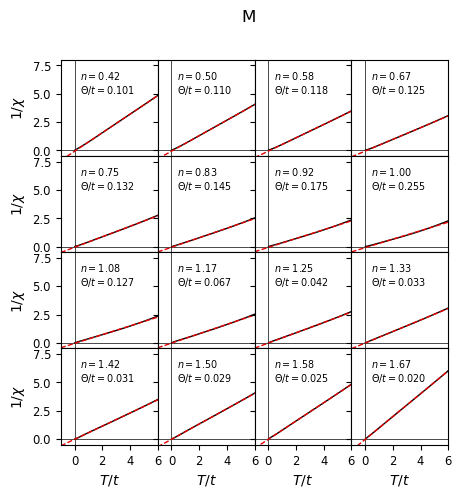

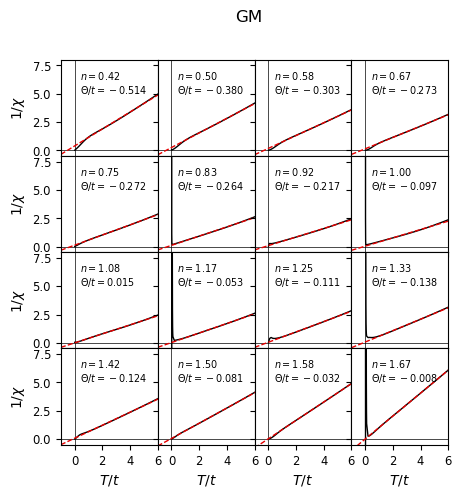

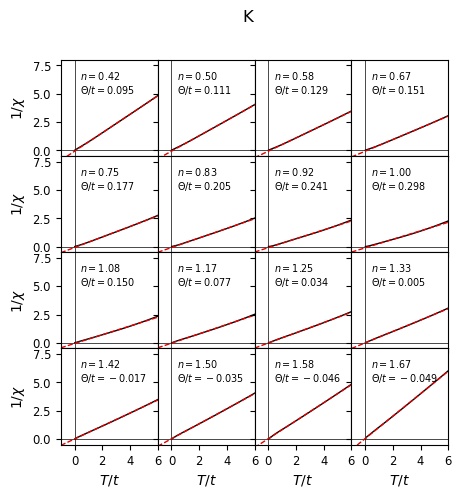

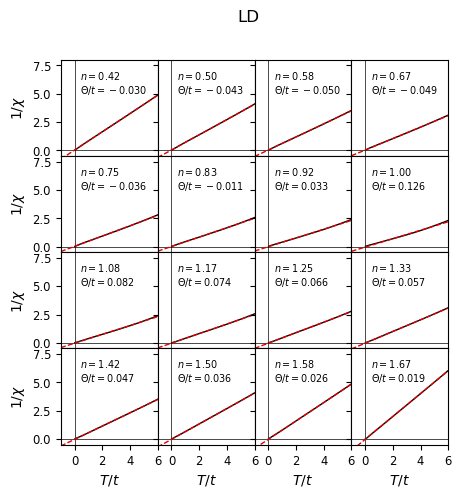

In [27]:
plot_susceptibility(canonical_df, canonical_fit_df, (4, 4); prefix="canonical_")

In [28]:
include("processdata.jl")

compute_grand_canonical (generic function with 2 methods)

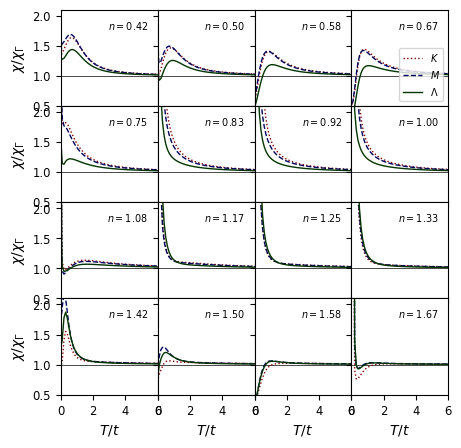

In [29]:
# plot_susceptibility_normalized(canonical_df, canonical_fit_df, (4, 4); prefix="canonical_")
plot_susceptibility_normalized(canonical_df, canonical_fit_df,
    ["K", "M", "LD"],
    Dict("K"=>(color="xkcd:dark red", linestyle=":", label=raw"$K$"),
         "M"=>(color="xkcd:dark blue", linestyle="--", label=raw"$M$"),
         "LD"=>(color="xkcd:dark green", linestyle="-", label=raw"$\Lambda$"),
        
        ),
    (4, 4); prefix="canonical_")

In [30]:
canonical_df

1744×10 DataFrame
  Row │ charge  density   temperature  specific_heat  susceptibilities_0  susc ⋯
      │ Int64   Float64   Float64      Float64        Float64             Floa ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │      5  0.416667         0.01      0.0253041         113.772           ⋯
    2 │      5  0.416667         0.02      0.0249816          51.8625
    3 │      5  0.416667         0.03      0.0327642          32.7715
    4 │      5  0.416667         0.04      0.0398848          23.8397
    5 │      5  0.416667         0.05      0.0424247          18.7573          ⋯
    6 │      5  0.416667         0.06      0.0417825          15.4961
    7 │      5  0.416667         0.07      0.0397799          13.2244
    8 │      5  0.416667         0.08      0.0375142          11.5462
    9 │      5  0.416667         0.09      0.0354757          10.2514          ⋯
   10 │      5  0.416667         0.1       0.0338152           9.21892
   11 │      5  0.416667         0.2       0.0285119           4.52836
  ⋮   │   ⋮        ⋮           ⋮             ⋮                ⋮                ⋱
 1735 │     20  1.66667          9.1       0.0289137           0.107294
 1736 │     20  1.66667          9.2       0.0286423           0.106091        ⋯
 1737 │     20  1.66667          9.3       0.0283752           0.104914
 1738 │     20  1.66667          9.4       0.028112            0.103762
 1739 │     20  1.66667          9.5       0.0278528           0.102634
 1740 │     20  1.66667          9.6       0.0275973           0.101529        ⋯
 1741 │     20  1.66667          9.7       0.0273455           0.100447
 1742 │     20  1.66667          9.8       0.0270972           0.0993869
 1743 │     20  1.66667          9.9       0.0268523           0.098348
 1744 │     20  1.66667         10.0       0.0266107           0.0973299       ⋯
                                                 5 columns and 1723 rows omitted

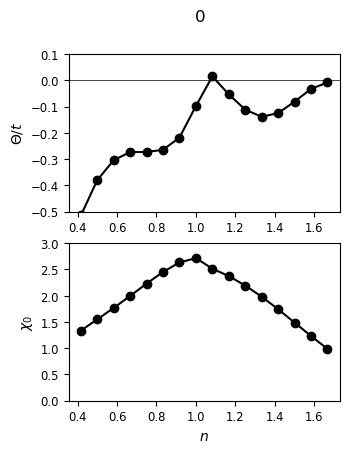

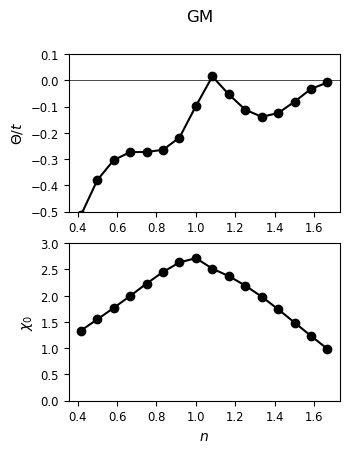

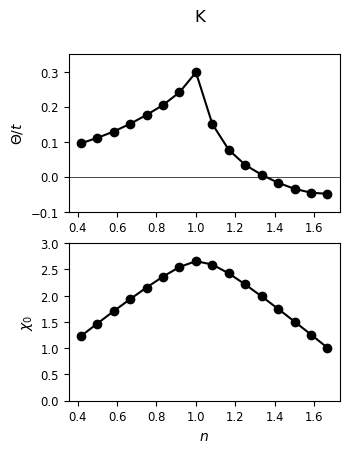

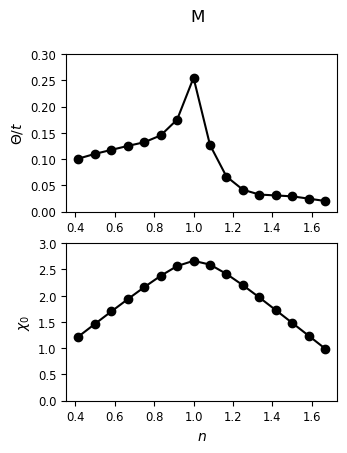

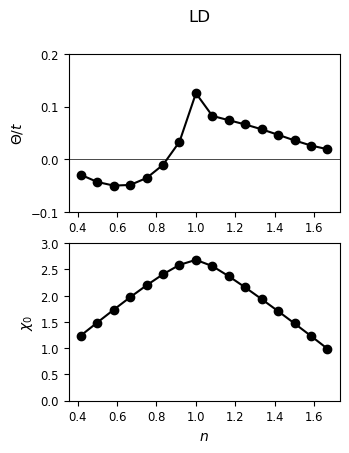

In [31]:
plot_curie_weiss_fit(canonical_fit_df, "0", (-0.5, 0.1), (0, 3); prefix="canonical_")
plot_curie_weiss_fit(canonical_fit_df, "GM", (-0.5, 0.1), (0, 3); prefix="canonical_")
plot_curie_weiss_fit(canonical_fit_df, "K", (-0.1, 0.35), (0, 3); prefix="canonical_")
plot_curie_weiss_fit(canonical_fit_df, "M", (0.0, 0.3), (0, 3); prefix="canonical_")
plot_curie_weiss_fit(canonical_fit_df, "LD", (-0.1, 0.2), (0, 3); prefix="canonical_")

In [32]:
select_temperatures = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0];

In [33]:
# structure_factor_df = compute_structure_factor(
#     sort(
#         filter(
#             row -> 
#             (0.4 <= row.density <= 1.7)
#             && (row.temperature in select_temperatures),
#             df), [:density, :temperature])
#     )
# ;

In [34]:
include("processdata.jl")

compute_grand_canonical (generic function with 2 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


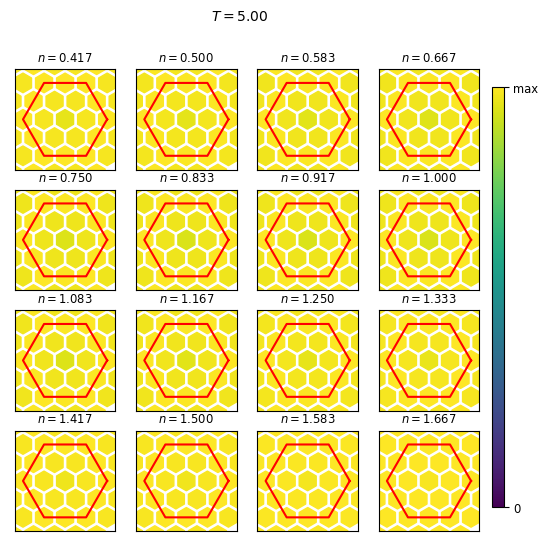

In [35]:
plot_structure_factor_map(
    sort(
        filter(
            row -> (0.4 <= row.density <= 1.7) && (row.temperature in select_temperatures),
            canonical_df
        ),
        [:temperature, :density]
    ),
    latticedata, 4, 4;
    marker="h", markersize=200,
    prefix="canonical_",
)

In [36]:
# plot_structure_factor_map_nogamma(
#     sort(
#         filter(
#             row -> (0.4 <= row.density <= 1.7) && (row.temperature in select_temperatures),
#             canonical_df
#         ),
#         [:temperature, :density]
#     ),
#     latticedata, 4, 4;
#     marker="h", markersize=200,
#     prefix="canonical_",
# )

# Grand Canonical Ensemble

In [37]:
include("processdata.jl")

compute_grand_canonical (generic function with 2 methods)

In [38]:
grand_canonical_df = compute_grand_canonical(df, latticedata, kpoint_indices)

1744×11 DataFrame
  Row │ density  converged_density  chemical_potential  temperature  specific_ ⋯
      │ Float64  Float64            Float64             Float64      Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     0.2                0.2           -0.541551         0.01     0.0026 ⋯
    2 │     0.2                0.2           -0.56772          0.02     0.0055
    3 │     0.2                0.2           -0.597639         0.03     0.0083
    4 │     0.2                0.2           -0.628868         0.04     0.0113
    5 │     0.2                0.2           -0.660686         0.05     0.0144 ⋯
    6 │     0.2                0.2           -0.692825         0.06     0.0175
    7 │     0.2                0.2           -0.725164         0.07     0.0207
    8 │     0.2                0.2           -0.757638         0.08     0.0238
    9 │     0.2                0.2           -0.790208         0.09     0.0270 ⋯
   10 │     0.2                0.2           -0.822852         0.1      0.0303
   11 │     0.2                0.2           -1.15141          0.2      0.0632
  ⋮   │    ⋮             ⋮                  ⋮                ⋮             ⋮   ⋱
 1735 │     1.7                1.7           34.4679           9.1      5.3253
 1736 │     1.7                1.7           34.6289           9.2      5.3964 ⋯
 1737 │     1.7                1.7           34.7901           9.3      5.4676
 1738 │     1.7                1.7           34.9514           9.4      5.5390
 1739 │     1.7                1.7           35.1129           9.5      5.6105
 1740 │     1.7                1.7           35.2745           9.6      5.6821 ⋯
 1741 │     1.7                1.7           35.4363           9.7      5.7539
 1742 │     1.7                1.7           35.5982           9.8      5.8258
 1743 │     1.7                1.7           35.7602           9.9      5.8977
 1744 │     1.7                1.7           35.9225          10.0      5.9698 ⋯
                                                 7 columns and 1723 rows omitted

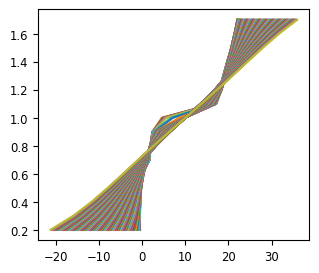

In [49]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
for sdf in groupby(grand_canonical_df, [:temperature])
    ax.plot(sdf.chemical_potential, sdf.density)
end

In [39]:
grand_canonical_fit_df = compute_canonical_fit(grand_canonical_df, model, [0.7, 5.5], latticedata)

16×11 DataFrame
 Row │ density  intercept_0  intercept_M  intercept_GM  intercept_K  intercept ⋯
     │ Float64  Float64      Float64      Float64       Float64      Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0.2  -1.59509       0.0654769   -1.59509      0.0578644    0.028692 ⋯
   2 │     0.3  -0.80779       0.087492    -0.80779      0.0807728   -0.000990
   3 │     0.4  -0.525095      0.102423    -0.525095     0.100571    -0.023361
   4 │     0.5  -0.381315      0.114192    -0.381315     0.121276    -0.036029
   5 │     0.6  -0.30485       0.125371    -0.30485      0.145509    -0.037878 ⋯
   6 │     0.7  -0.2667        0.139059    -0.2667       0.175289    -0.025606
   7 │     0.8  -0.234843      0.162971    -0.234843     0.214006     0.007206
   8 │     0.9  -0.160448      0.217732    -0.160448     0.273425     0.077246
   9 │     1.0  -1.06846e-5    0.326065    -1.06846e-5   0.366241     0.206181 ⋯
  10 │     1.1   0.00885458    0.173832     0.00885458   0.197252     0.124932
  11 │     1.2  -0.0490743     0.0898311   -0.0490743    0.0947117    0.087903
  12 │     1.3  -0.0962111     0.0540476   -0.0962111    0.0382833    0.069373
  13 │     1.4  -0.103927      0.0396385   -0.103927     0.00268256   0.055184 ⋯
  14 │     1.5  -0.0771834     0.0327617   -0.0771834   -0.0214401    0.042350
  15 │     1.6  -0.0412632     0.0271195   -0.0412632   -0.0360644    0.031142
  16 │     1.7  -0.0149857     0.0212085   -0.0149857   -0.0408461    0.022003
                                                               6 columns omitted

In [40]:
grand_canonical_df.specific_heat

1744-element Vector{Float64}:
 0.0026554025898425
 0.005521602096318172
 0.008387572655305715
 0.011372047586070504
 0.014435664108016034
 0.01755097095380699
 0.020702336087873887
 0.023880896067026335
 0.027081527528278252
 0.03030116689906492
 0.06327674057004627
 0.0973949783480145
 0.13432047633761265
 ⋮
 5.183533845445483
 5.254362677582928
 5.325333755350892
 5.396443120611155
 5.467686943285706
 5.539061472891971
 5.610563070685888
 5.68218826161683
 5.753933459498738
 5.825795703085965
 5.897771421342602
 5.969857499696081

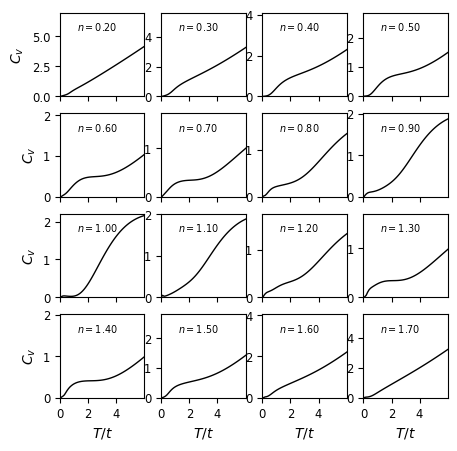

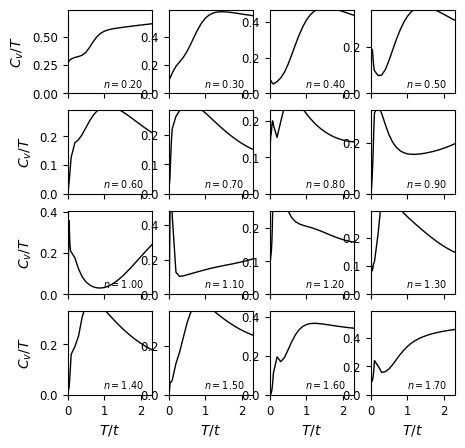

In [41]:
plot_specific_heat(grand_canonical_df, 4, 4; prefix="grandcanonical_")

In [42]:
grand_canonical_fit_df

16×11 DataFrame
 Row │ density  intercept_0  intercept_M  intercept_GM  intercept_K  intercept ⋯
     │ Float64  Float64      Float64      Float64       Float64      Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0.2  -1.59509       0.0654769   -1.59509      0.0578644    0.028692 ⋯
   2 │     0.3  -0.80779       0.087492    -0.80779      0.0807728   -0.000990
   3 │     0.4  -0.525095      0.102423    -0.525095     0.100571    -0.023361
   4 │     0.5  -0.381315      0.114192    -0.381315     0.121276    -0.036029
   5 │     0.6  -0.30485       0.125371    -0.30485      0.145509    -0.037878 ⋯
   6 │     0.7  -0.2667        0.139059    -0.2667       0.175289    -0.025606
   7 │     0.8  -0.234843      0.162971    -0.234843     0.214006     0.007206
   8 │     0.9  -0.160448      0.217732    -0.160448     0.273425     0.077246
   9 │     1.0  -1.06846e-5    0.326065    -1.06846e-5   0.366241     0.206181 ⋯
  10 │     1.1   0.00885458    0.173832     0.00885458   0.197252     0.124932
  11 │     1.2  -0.0490743     0.0898311   -0.0490743    0.0947117    0.087903
  12 │     1.3  -0.0962111     0.0540476   -0.0962111    0.0382833    0.069373
  13 │     1.4  -0.103927      0.0396385   -0.103927     0.00268256   0.055184 ⋯
  14 │     1.5  -0.0771834     0.0327617   -0.0771834   -0.0214401    0.042350
  15 │     1.6  -0.0412632     0.0271195   -0.0412632   -0.0360644    0.031142
  16 │     1.7  -0.0149857     0.0212085   -0.0149857   -0.0408461    0.022003
                                                               6 columns omitted

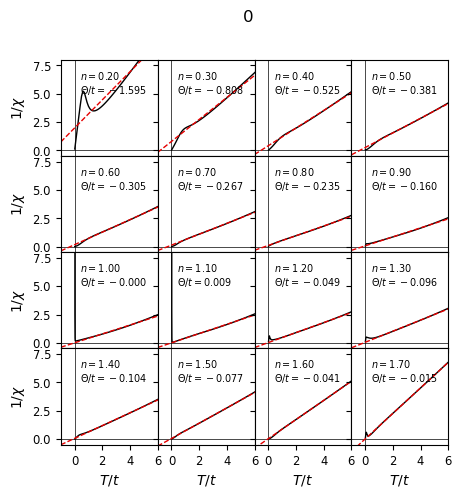

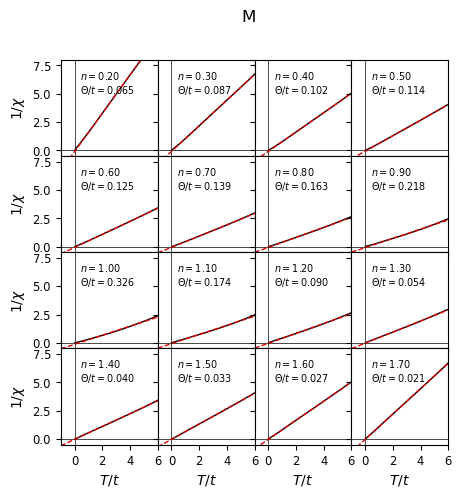

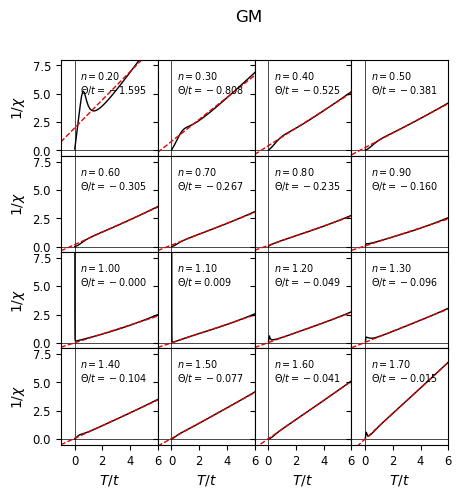

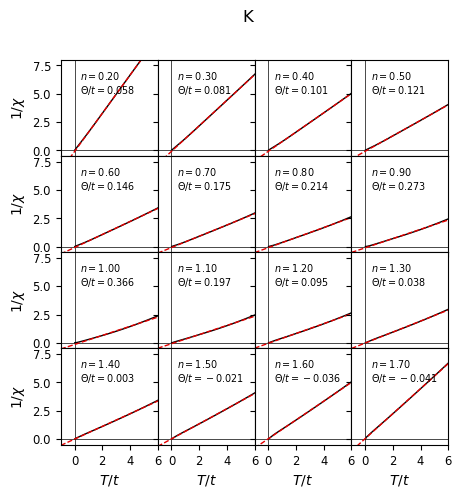

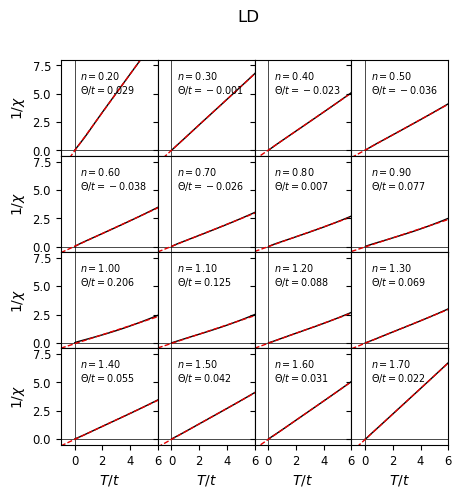

In [43]:
plot_susceptibility(grand_canonical_df, grand_canonical_fit_df, (4, 4); prefix="grandcanonical_")

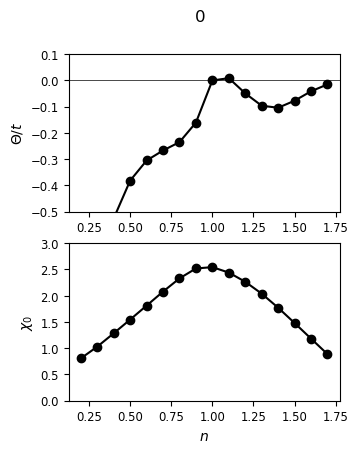

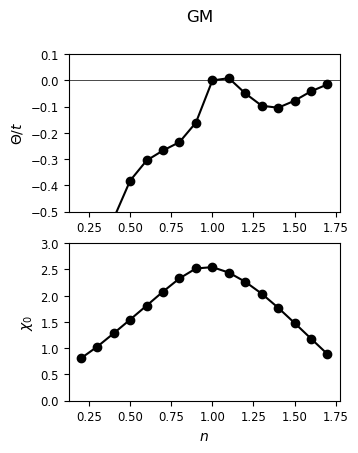

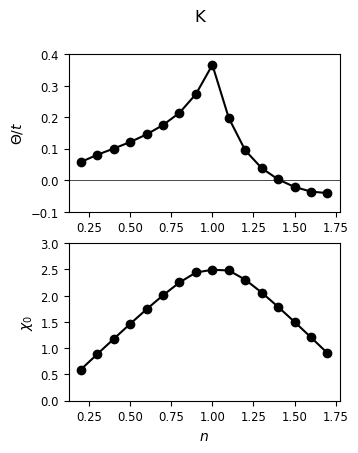

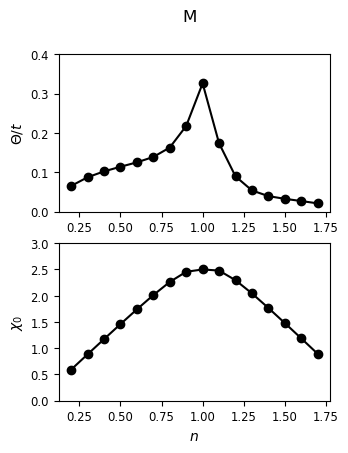

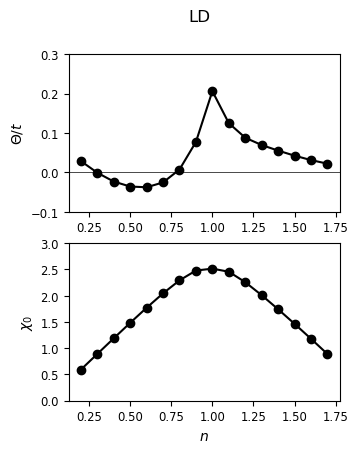

In [44]:
# plot_curie_weiss_fit(grand_canonical_fit_df, "0", (-1., 0.3), (0, 2); prefix="grandcanonical_")
# plot_curie_weiss_fit(grand_canonical_fit_df, "GM", (-1., 0.3), (0, 2); prefix="grandcanonical_")
# plot_curie_weiss_fit(grand_canonical_fit_df, "SM", (-0.05, 0.25), (0, 2.5); prefix="grandcanonical_")
# plot_curie_weiss_fit(grand_canonical_fit_df, "K", (-0.2, 0.35), (0, 2.5); prefix="grandcanonical_")


plot_curie_weiss_fit(grand_canonical_fit_df, "0", (-0.5, 0.1), (0, 3); prefix="grandcanonical_")
plot_curie_weiss_fit(grand_canonical_fit_df, "GM", (-0.5, 0.1), (0, 3); prefix="grandcanonical_")
plot_curie_weiss_fit(grand_canonical_fit_df, "K", (-0.1, 0.4), (0, 3); prefix="grandcanonical_")
plot_curie_weiss_fit(grand_canonical_fit_df, "M", (0.0, 0.4), (0, 3); prefix="grandcanonical_")
plot_curie_weiss_fit(grand_canonical_fit_df, "LD", (-0.1, 0.3), (0, 3); prefix="grandcanonical_")

In [45]:
grand_canonical_df.Sq

1744-element Vector{Vector{Float64}}:
 [0.00720225660051548, 0.05394050123421289, 0.05062733361428626, 0.05356366049724436, 0.05062733361428626, 0.05394050123421287, 0.05356366049724437, 0.05394050123421289, 0.053940501234212894, 0.05356366049724436, 0.05394050123421289, 0.053940501234212936]
 [0.008052852790178321, 0.053524048194828484, 0.051791372053069114, 0.05331912619734556, 0.05179137205306913, 0.053524048194828484, 0.05331912619734557, 0.053524048194828484, 0.05352404819482849, 0.05331912619734556, 0.05352404819482847, 0.053524048194828526]
 [0.008221966766764711, 0.05339802572818787, 0.05211838475429538, 0.05329054387718703, 0.05211838475429538, 0.05339802572818786, 0.05329054387718703, 0.05339802572818787, 0.05339802572818788, 0.05329054387718703, 0.05339802572818786, 0.05339802572818791]
 [0.008296493191452975, 0.05334258061084645, 0.052249285340807805, 0.05328650803793499, 0.052249285340807805, 0.05334258061084643, 0.05328650803793499, 0.05334258061084645, 0.0533425806108464

In [46]:
    sort(
        filter(
            row -> (0.4 <= row.density <= 1.7) && (row.temperature in select_temperatures),
            grand_canonical_df
        ),
        [:temperature, :density]
    )

126×11 DataFrame
 Row │ density  converged_density  chemical_potential  temperature  specific_h ⋯
     │ Float64  Float64            Float64             Float64      Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0.4                0.4          -0.429237          0.01    0.000931 ⋯
   2 │     0.5                0.5          -0.245266          0.01    0.001761
   3 │     0.6                0.6           0.0147984         0.01    1.4643e-
   4 │     0.7                0.7           1.76297           0.01    0.000305
   5 │     0.8                0.8           1.86391           0.01    0.001244 ⋯
   6 │     0.9                0.9           2.39677           0.01    6.74151e
   7 │     1.0                1.0           7.05974           0.01    3.52916e
   8 │     1.1                1.1          16.5916            0.01    3.89828e
   9 │     1.2                1.2          18.0565            0.01    0.000967 ⋯
  10 │     1.3                1.3          18.7876            0.01    0.001061
  11 │     1.4                1.4          19.7063            0.01    5.46826e
  ⋮  │    ⋮             ⋮                  ⋮                ⋮             ⋮    ⋱
 117 │     0.8                0.8           3.08705           5.0     1.07347
 118 │     0.9                0.9           6.16874           5.0     1.64031  ⋯
 119 │     1.0                1.0          10.0127            5.0     1.98408
 120 │     1.1                1.1          13.8642            5.0     1.65125
 121 │     1.2                1.2          16.9557            5.0     1.07809
 122 │     1.3                1.3          19.4539            5.0     0.725643 ⋯
 123 │     1.4                1.4          21.6368            5.0     0.72939
 124 │     1.5                1.5          23.6925            5.0     1.08987
 125 │     1.6                1.6          25.7695            5.0     1.74783
 126 │     1.7                1.7          28.0374            5.0     2.58681  ⋯
                                                  7 columns and 105 rows omitted

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


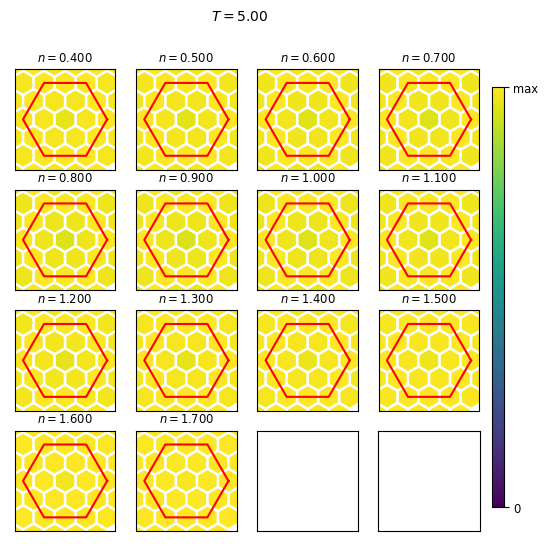

In [47]:
plot_structure_factor_map(
    sort(
        filter(
            row -> (0.4 <= row.density <= 1.7) && (row.temperature in select_temperatures),
            grand_canonical_df
        ),
        [:temperature, :density]
    ),
    latticedata, 4, 4;
    marker="h", markersize=200,
    prefix="grandcanonical_",
)